In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# train 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/AIVLE/air/train_data.csv')

# test 데이터 불러오기
test = pd.read_csv('/content/drive/MyDrive/AIVLE/air/test_data.csv')
test.tail()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7
7388,1.70,42.51,0.7,22.01,1801.0,60.01,3.00,7


Epoch 1/20
11/11 [==============================] - 11s 98ms/step - loss: 0.2193 - val_loss: 0.1624
Epoch 2/20
11/11 [==============================] - 0s 9ms/step - loss: 0.2076 - val_loss: 0.1522
Epoch 3/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1940 - val_loss: 0.1407
Epoch 4/20
11/11 [==============================] - 0s 10ms/step - loss: 0.1789 - val_loss: 0.1271
Epoch 5/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1595 - val_loss: 0.1101
Epoch 6/20
11/11 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.0862
Epoch 7/20
11/11 [==============================] - 0s 10ms/step - loss: 0.0958 - val_loss: 0.0488
Epoch 8/20
11/11 [==============================] - 0s 10ms/step - loss: 0.0381 - val_loss: 0.0152
Epoch 9/20
11/11 [==============================] - 0s 10ms/step - loss: 0.0200 - val_loss: 0.0134
Epoch 10/20
11/11 [==============================] - 0s 8ms/step - loss: 0.0166 - val_loss: 0.0149
Epoch 11/2

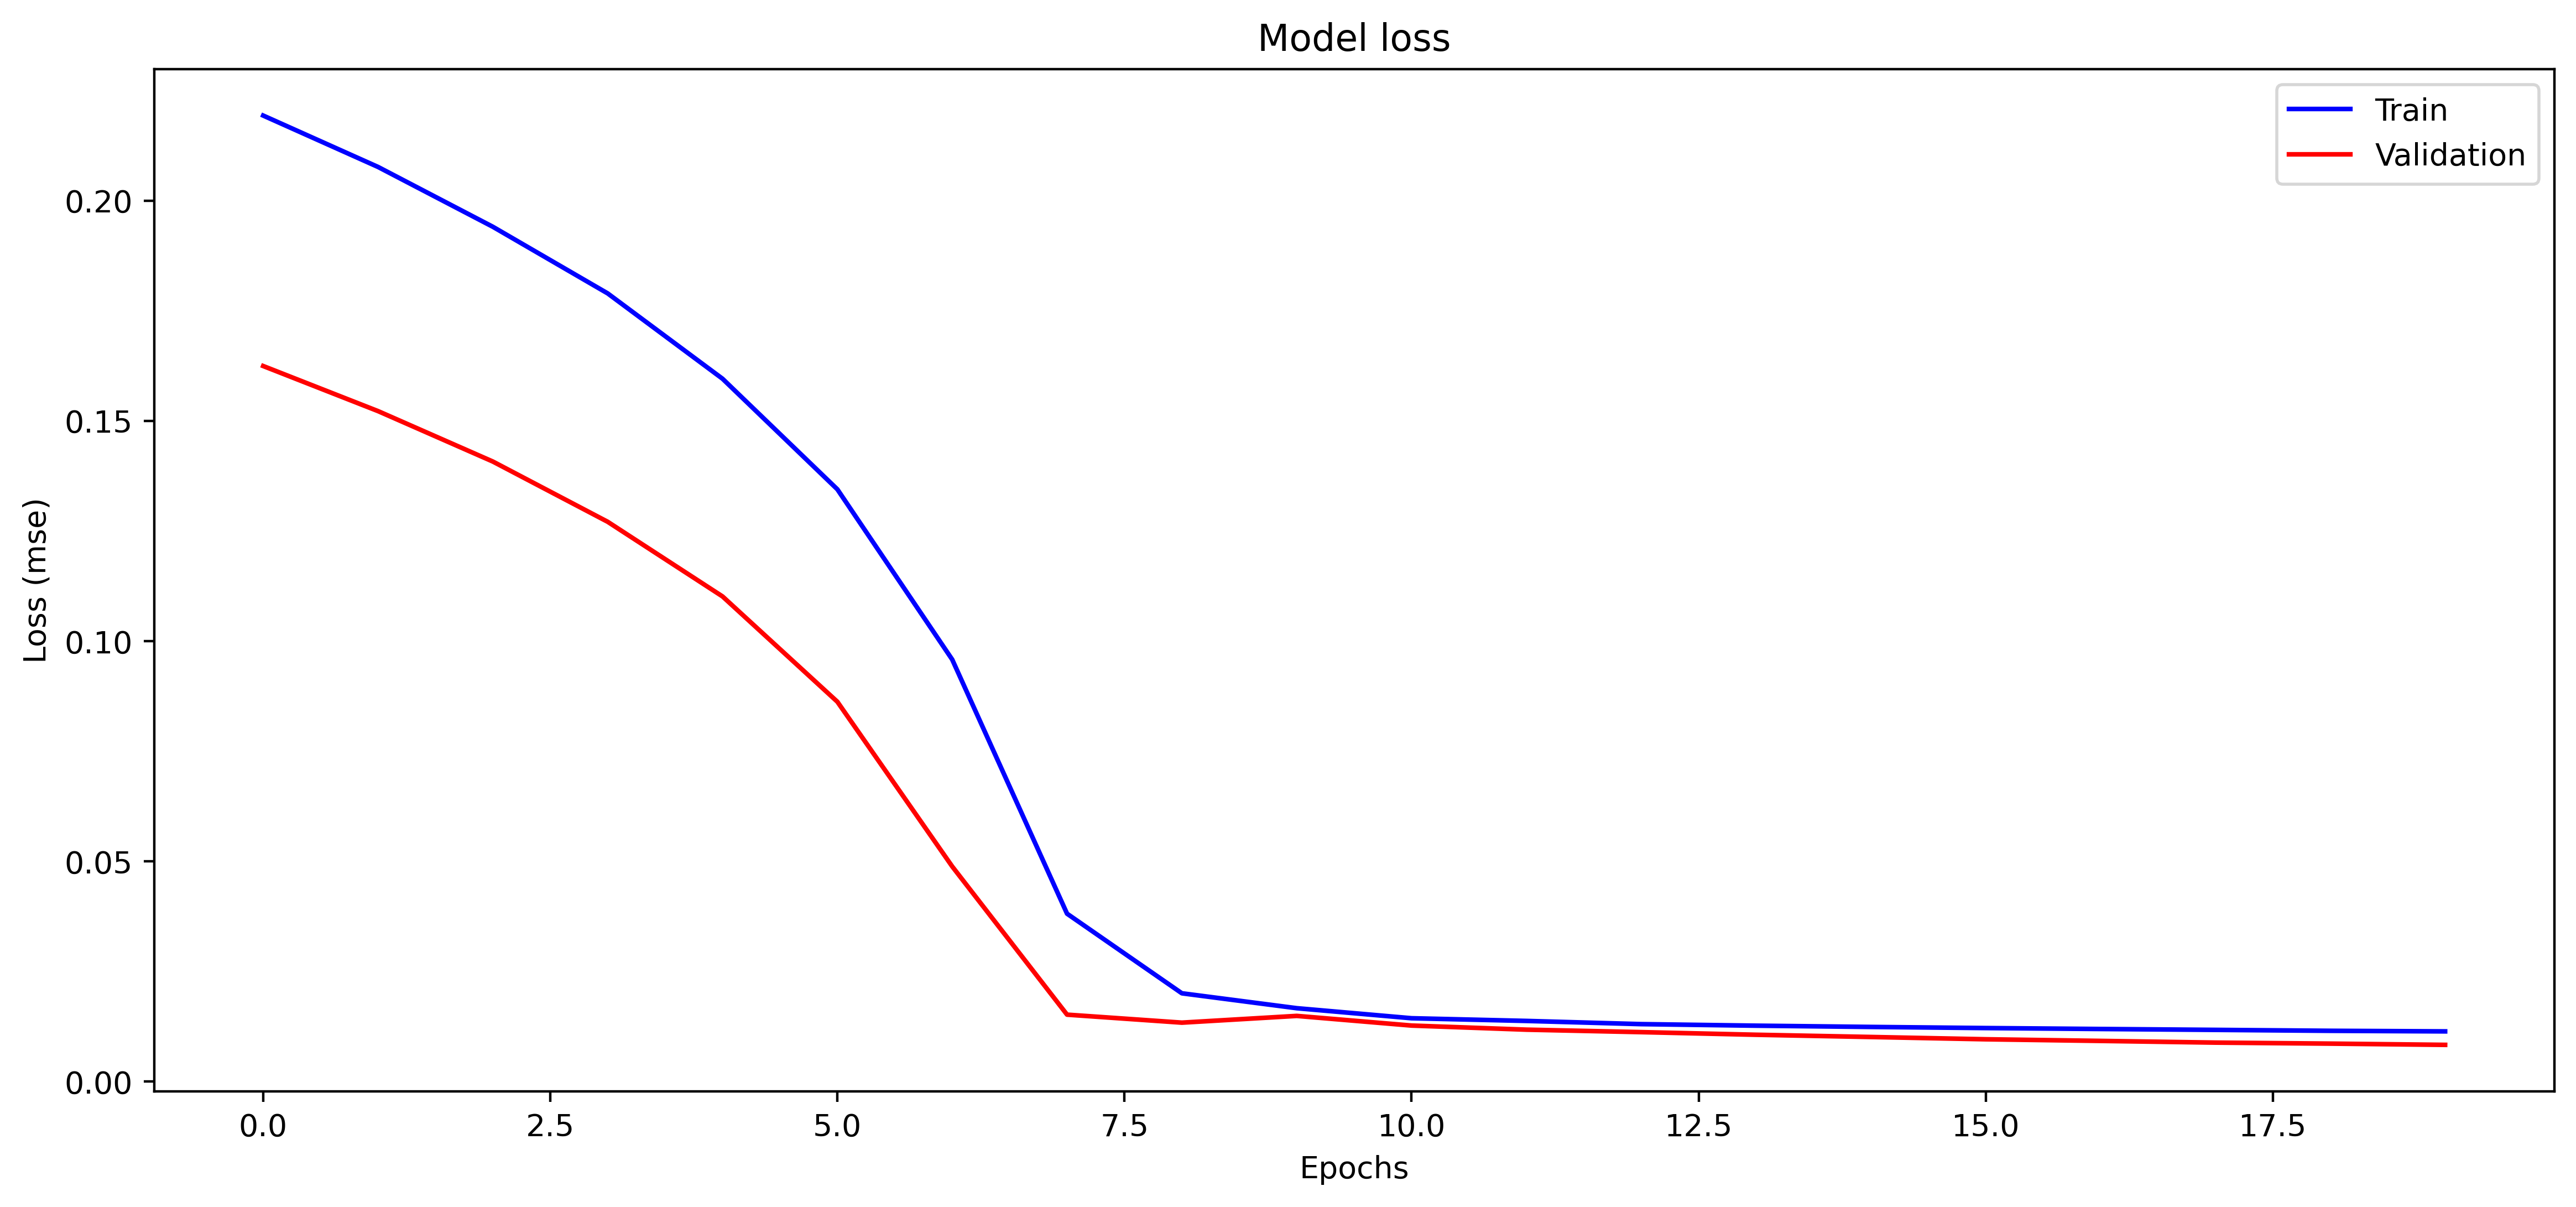

35/35 [==============================] - 0s 2ms/step


,Loss_mse,Threshold,Anomaly
1296,0.021872,0.274952,0
1297,0.154651,0.274952,0
1298,0.068596,0.274952,0
1299,0.075770,0.274952,0
1300,0.064169,0.274952,0


In [231]:
from keras.layers.rnn import TimeDistributed
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from keras.optimizers import Adam

clear_session()

train_1 = train[train['type'] == 1].iloc[:, :-1]
test_1 = test[test['type'] == 1].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_1)
test_scaled = scaler.transform(test_1)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])


# LSTM AE 모델 구축
def ae_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(64, activation='relu', return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(64, activation='relu', return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)

  model = Model(inputs, output)
  
  return model


# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=20, batch_size=32, validation_split=0.1).history

# 시각화
#fig, ax = plt.subplots(figsize=(14, 6), dpi=400)
#ax.plot(history['loss'], 'b', label='Train')
#ax.plot(history['val_loss'], 'r', label='Validation')
#ax.set_title('Model loss')
#ax.set_ylabel('Loss (mse)')
#ax.set_xlabel('Epochs')
#ax.legend()
#plt.show()

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_1.columns)
train_pred.index = train_1.index

scored = pd.DataFrame(index=train_1.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)

# test 재구성 오차
threshold = np.percentile(scored, 100)     

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_1.columns)
test_pred.index = test_1.index

test_scored = pd.DataFrame(index=test_1.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

In [232]:
test_scored['Anomaly'].value_counts()

0    1107
Name: Anomaly, dtype: int64

In [169]:
# 결과
result = pd.read_csv('/content/drive/MyDrive/AIVLE/air/answer_sample.csv')
result_1 = result[result['type'] == 1]
result_1['label'] = test_scored['Anomaly'].values

In [276]:
clear_session()

train_2 = train[train['type'] == 2].iloc[:, :-1]
test_2 = test[test['type'] == 2].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_2)
test_scaled = scaler.transform(test_2)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])

# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=40, batch_size=32, validation_split=0.1).history

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_2.columns)
train_pred.index = train_2.index

scored = pd.DataFrame(index=train_2.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)


# test 재구성 오차
threshold = np.percentile(scored, 100)     

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_2.columns)
test_pred.index = test_2.index

test_scored = pd.DataFrame(index=test_2.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

Epoch 1/40
11/11 [==============================] - 10s 70ms/step - loss: 0.2632 - val_loss: 0.2526
Epoch 2/40
11/11 [==============================] - 0s 9ms/step - loss: 0.2508 - val_loss: 0.2390
Epoch 3/40
11/11 [==============================] - 0s 8ms/step - loss: 0.2368 - val_loss: 0.2235
Epoch 4/40
11/11 [==============================] - 0s 8ms/step - loss: 0.2203 - val_loss: 0.2048
Epoch 5/40
11/11 [==============================] - 0s 11ms/step - loss: 0.2001 - val_loss: 0.1814
Epoch 6/40
11/11 [==============================] - 0s 9ms/step - loss: 0.1733 - val_loss: 0.1482
Epoch 7/40
11/11 [==============================] - 0s 9ms/step - loss: 0.1315 - val_loss: 0.0949
Epoch 8/40
11/11 [==============================] - 0s 9ms/step - loss: 0.0641 - val_loss: 0.0201
Epoch 9/40
11/11 [==============================] - 0s 9ms/step - loss: 0.0222 - val_loss: 0.0121
Epoch 10/40
11/11 [==============================] - 0s 10ms/step - loss: 0.0133 - val_loss: 0.0100
Epoch 11/40
11/

,Loss_mse,Threshold,Anomaly
2403,0.005467,0.014598,0
2404,0.002058,0.014598,0
2405,0.006408,0.014598,0
2406,0.009694,0.014598,0
2407,0.005024,0.014598,0


In [277]:
test_scored['Anomaly'].value_counts()

0    1073
1      25
Name: Anomaly, dtype: int64

In [278]:
# 결과
result_2 = result[result['type'] == 2]
result_2['label'] = test_scored['Anomaly'].values

In [298]:
clear_session()

train_3 = train[train['type'] == 3].iloc[:, :-1]
test_3 = test[test['type'] == 3].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_3)
test_scaled = scaler.transform(test_3)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])

# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=40, batch_size=32, validation_split=0.1).history

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_3.columns)
train_pred.index = train_3.index

scored = pd.DataFrame(index=train_3.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)

# test 재구성 오차
threshold = np.percentile(scored, 100)     

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_3.columns)
test_pred.index = test_3.index

test_scored = pd.DataFrame(index=test_3.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

Epoch 1/50
9/9 [==============================] - 9s 94ms/step - loss: 0.3140 - val_loss: 0.2361
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.3027 - val_loss: 0.2258
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.2899 - val_loss: 0.2144
Epoch 4/50
9/9 [==============================] - 0s 13ms/step - loss: 0.2757 - val_loss: 0.2016
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.2593 - val_loss: 0.1866
Epoch 6/50
9/9 [==============================] - 0s 10ms/step - loss: 0.2393 - val_loss: 0.1680
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 0.2131 - val_loss: 0.1428
Epoch 8/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1740 - val_loss: 0.1039
Epoch 9/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1070 - val_loss: 0.0422
Epoch 10/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0317 - val_loss: 0.0203
Epoch 11/50
9/9 [==================

,Loss_mse,Threshold,Anomaly
3501,0.058407,0.102932,0
3502,0.014553,0.102932,0
3503,0.005097,0.102932,0
3504,0.014737,0.102932,0
3505,0.025250,0.102932,0


In [299]:
test_scored['Anomaly'].value_counts()

0    897
1     21
Name: Anomaly, dtype: int64

In [300]:
# 결과
result_3 = result[result['type'] == 3]
result_3['label'] = test_scored['Anomaly'].values

In [266]:
clear_session()

train_4 = train[train['type'].isin([0, 4, 5, 6, 7])].iloc[:, :-1]
test_4 = test[test['type'].isin([0, 4, 5, 6, 7])].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_4)
test_scaled = scaler.transform(test_4)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])

# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=20, batch_size=32, validation_split=0.1).history

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_4.columns)
train_pred.index = train_4.index

scored = pd.DataFrame(index=train_4.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)

# test 재구성 오차
threshold = np.percentile(scored, 100)     

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_4.columns)
test_pred.index = test_4.index

test_scored = pd.DataFrame(index=test_4.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

Epoch 1/20
40/40 [==============================] - 7s 24ms/step - loss: 0.2635 - val_loss: 0.2347
Epoch 2/20
40/40 [==============================] - 0s 7ms/step - loss: 0.2049 - val_loss: 0.1651
Epoch 3/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0905 - val_loss: 0.0258
Epoch 4/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 5/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0107
Epoch 6/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 7/20
40/40 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/20
40/40 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 9/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 6.5990e-04
Epoch 10/20
40/40 [==============================] - 0s 9ms/step - loss: 2.1648e-04 - val_loss: 9.7787e-05
E

,Loss_mse,Threshold,Anomaly
0,0.001154,0.008029,0
1,0.000939,0.008029,0
2,0.008029,0.008029,0
3,0.001948,0.008029,0
4,0.001227,0.008029,0


In [267]:
test_scored['Anomaly'].value_counts()

0    3971
1     295
Name: Anomaly, dtype: int64

## 결과 저장

In [268]:
# 결과
result_0 = result[result['type'].isin([0, 4, 5, 6, 7])]
result_0['label'] = test_scored['Anomaly'].values

In [309]:
final = pd.concat([result_0, result_1], axis=0).sort_index()
final = pd.concat([final, result_2], axis=0).sort_index()
final = pd.concat([final, result_3], axis=0).sort_index()

In [280]:
final.to_csv('autoencoder_lstm.csv', index=False)

## 주은님꺼랑 비교

In [303]:
# 비교
joo = pd.read_csv('/content/drive/MyDrive/AIVLE/air/answer_949.csv')

In [305]:
cnt = 0
diff_idx = []
for i in range(len(list(joo['label'].values))):
    if list(joo['label'].values)[i] != list(final['label'].values)[i]:
        cnt += 1
        diff_idx.append(i)
cnt

26

In [306]:
final.iloc[diff_idx, :]

,type,label
627,0,1
2645,2,1
2646,2,1
2647,2,1
2648,2,1
2649,2,1
2657,2,1
2666,2,1
2668,2,1
3945,3,0


In [307]:
final[final['label'] == 1]['label'].index

Int64Index([ 585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
            ...
            6795, 6796, 6797, 6798, 6799, 6800, 7342, 7348, 7359, 7360],
           dtype='int64', length=341)

In [308]:
joo[joo['label'] == 1]['label'].index

Int64Index([ 585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
            ...
            6795, 6796, 6797, 6798, 6799, 6800, 7342, 7348, 7359, 7360],
           dtype='int64', length=321)